Bitcoin Dataset Head:
  Exchange Date        Bid        Ask       High        Low       Open  \
0   02-Dec-2024  95,407.00  95,415.00  98,193.00  94,395.00  97,378.66   
1   01-Dec-2024  97,827.00  97,828.00  97,889.33  95,758.00  96,886.32   
2   30-Nov-2024  96,827.00  96,830.00  97,562.47  96,120.00  97,464.46   
3   29-Nov-2024  97,449.00  97,467.00  98,735.00  95,022.98  95,136.00   
4   28-Nov-2024  95,136.00  95,137.00  96,668.65  94,667.73  96,412.00   

  Refresh Rate     BidNet  
0      340,829  -2,420.00  
1      278,067  +1,000.00  
2      278,067    -622.00  
3      278,067  +2,313.00  
4      290,556  -1,276.00  

Ethereum Dataset Head:
  Exchange Date       Bid       Ask      High       Low      Open  \
0   02-Dec-2024  3,616.50  3,616.90  3,762.20  3,555.00  3,724.80   
1   01-Dec-2024  3,708.20  3,708.80  3,748.00  3,660.40  3,722.50   
2   30-Nov-2024  3,722.00  3,722.10  3,735.03  3,569.20  3,592.30   
3   29-Nov-2024  3,593.60  3,594.20  3,649.20  3,536.24  3,572.09

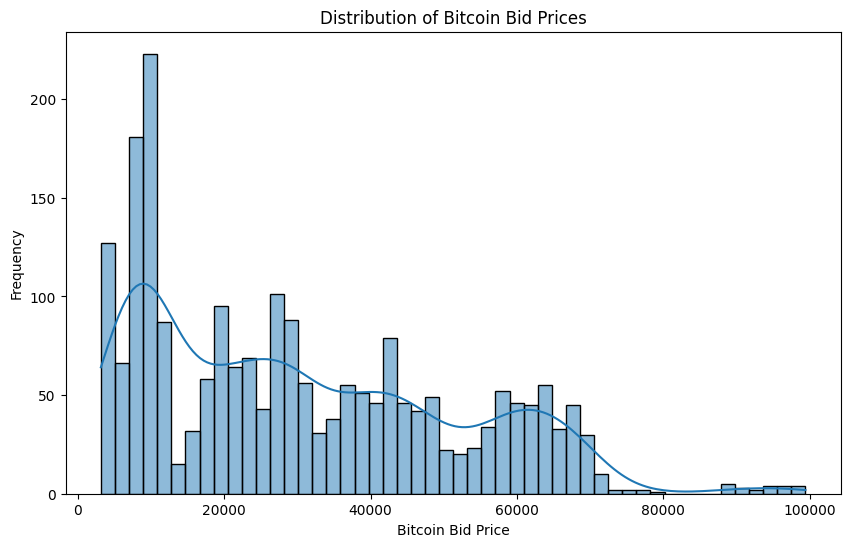

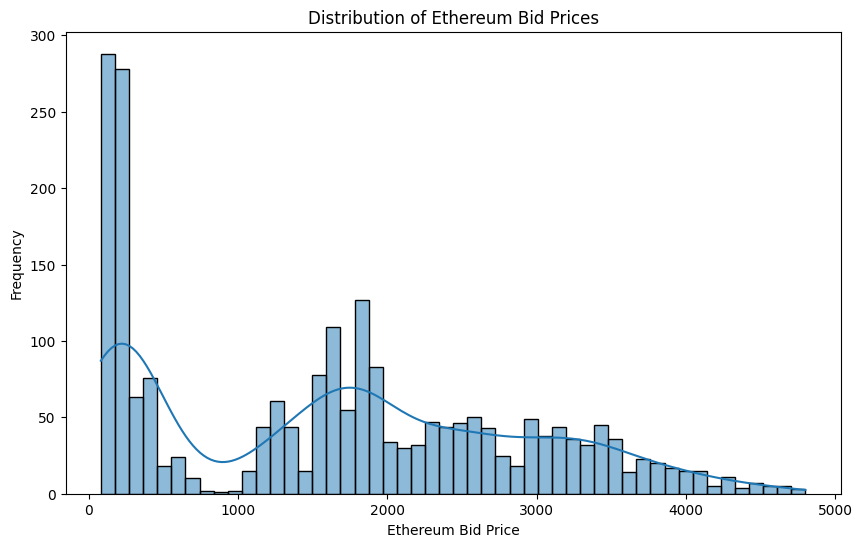


Best Parameters from RandomizedSearch: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.2}

Model Accuracy: 0.7581395348837209

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       229
           1       0.75      0.72      0.73       201

    accuracy                           0.76       430
   macro avg       0.76      0.76      0.76       430
weighted avg       0.76      0.76      0.76       430


ROC AUC Score: 0.7555888678876359


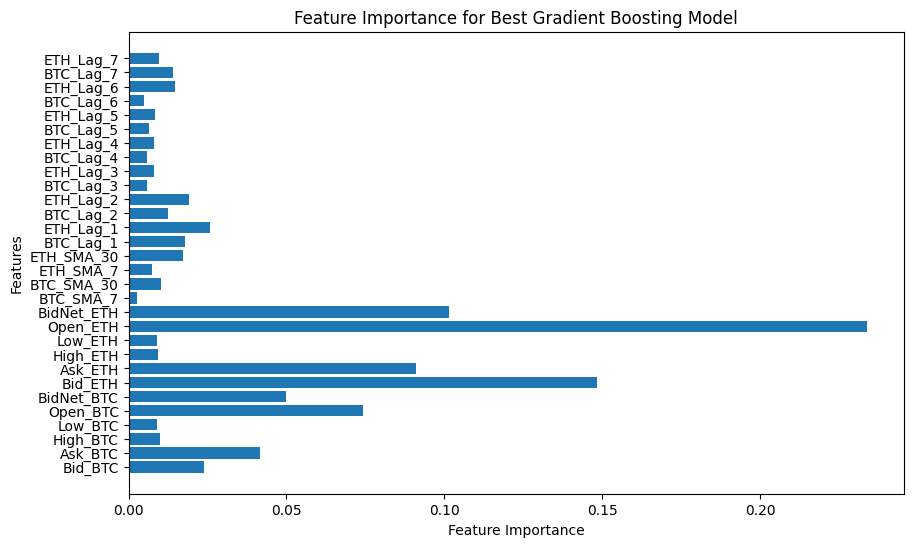

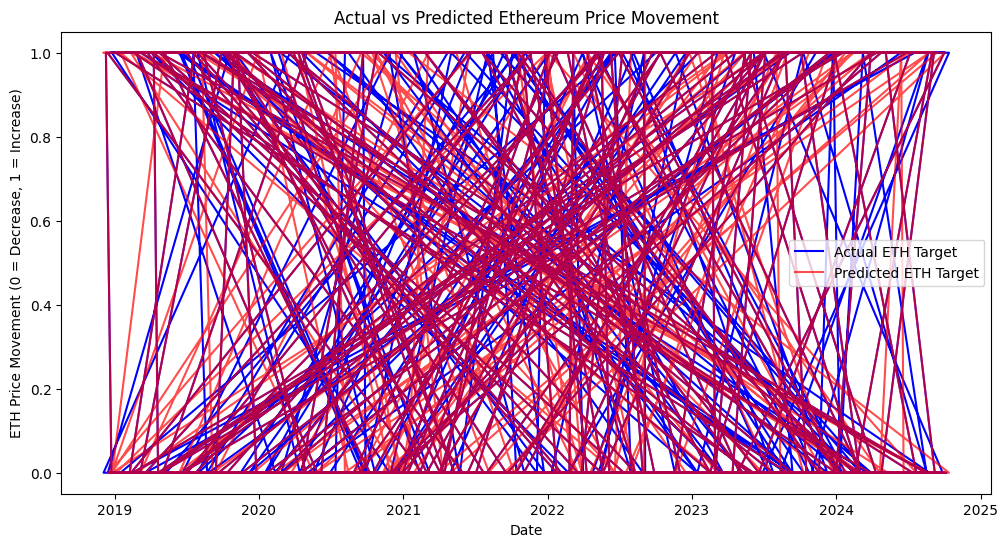

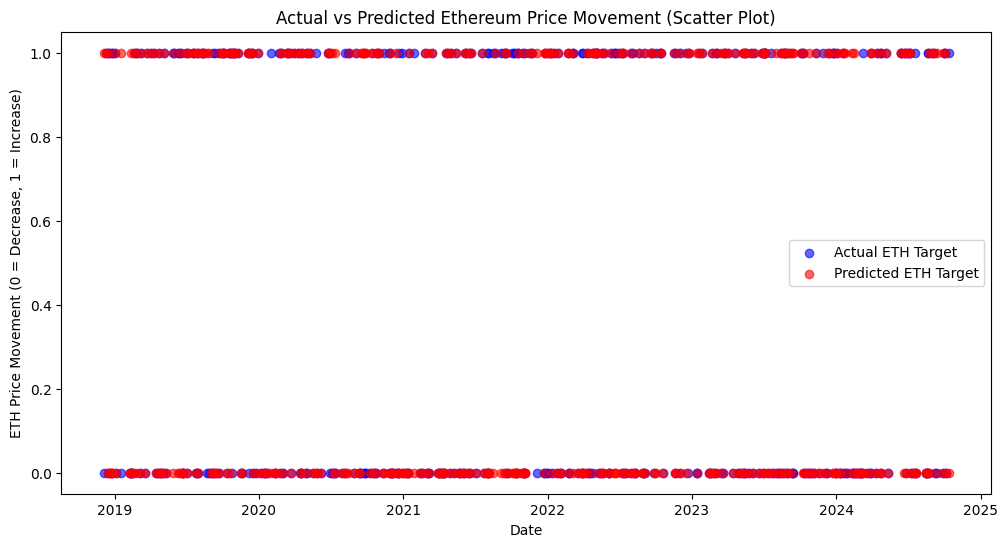

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
btc_df = pd.read_csv('BIT_Dataset.csv')
eth_df = pd.read_csv('ETH_Dataset.csv')

# Explore the data
print("Bitcoin Dataset Head:")
print(btc_df.head())
print("\nEthereum Dataset Head:")
print(eth_df.head())

print("\nBitcoin Dataset Info:")
btc_df.info()
print("\nEthereum Dataset Info:")
eth_df.info()

print("\nBitcoin Dataset Description:")
print(btc_df.describe())
print("\nEthereum Dataset Description:")
print(eth_df.describe())

# Ensure the date columns are consistent and align them
btc_df['Date'] = pd.to_datetime(btc_df['Exchange Date'])
eth_df['Date'] = pd.to_datetime(eth_df['Exchange Date'])

# Merge datasets on Date
data = pd.merge(btc_df, eth_df, on='Date', suffixes=('_BTC', '_ETH'))

# Drop unnecessary columns after merging
data.drop(columns=['Exchange Date_BTC', 'Exchange Date_ETH'], inplace=True)

# Clean the data
# Convert relevant columns to numeric
for col in ['Bid_BTC', 'Ask_BTC', 'High_BTC', 'Low_BTC', 'Open_BTC', 'BidNet_BTC', 'Bid_ETH', 'Ask_ETH', 'High_ETH', 'Low_ETH', 'Open_ETH', 'BidNet_ETH']:
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', '').str.replace(r'[^0-9.]', '', regex=True), errors='coerce')

# Handle missing values
# Drop rows with any remaining NaN values
data.dropna(inplace=True)

# Explore the cleaned dataset
print("\nCleaned Merged Dataset Head:")
print(data.head())
print("\nCleaned Merged Dataset Info:")
data.info()
print("\nCleaned Merged Dataset Description:")
print(data.describe())

# Visualize data distributions
plt.figure(figsize=(10, 6))
sns.histplot(data['Bid_BTC'], bins=50, kde=True)
plt.title('Distribution of Bitcoin Bid Prices')
plt.xlabel('Bitcoin Bid Price')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['Bid_ETH'], bins=50, kde=True)
plt.title('Distribution of Ethereum Bid Prices')
plt.xlabel('Ethereum Bid Price')
plt.ylabel('Frequency')
plt.show()

# Handle outliers using IQR
for col in ['Bid_BTC', 'Bid_ETH']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

# Feature Engineering
# Create moving averages as new features
data['BTC_SMA_7'] = data['Bid_BTC'].rolling(window=7).mean()
data['BTC_SMA_30'] = data['Bid_BTC'].rolling(window=30).mean()
data['ETH_SMA_7'] = data['Bid_ETH'].rolling(window=7).mean()
data['ETH_SMA_30'] = data['Bid_ETH'].rolling(window=30).mean()

# Create lagged features for price trends
for lag in range(1, 8):
    data[f'BTC_Lag_{lag}'] = data['Bid_BTC'].shift(lag)
    data[f'ETH_Lag_{lag}'] = data['Bid_ETH'].shift(lag)

# Drop rows with NaN values generated by lagging and moving averages
data.dropna(inplace=True)

# Modeling Preparation
# Define target: Predict if Ethereum price will increase (1) or decrease (0) the next day
data['ETH_Target'] = np.where(data['Bid_ETH'].shift(-1) > data['Bid_ETH'], 1, 0)

# Define features and target variable
features = [col for col in data.columns if col not in ['Date', 'ETH_Target', 'Refresh Rate_BTC', 'Refresh Rate_ETH']]
X = data[features]
y = data['ETH_Target']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbm = GradientBoostingClassifier(random_state=42)
random_search = RandomizedSearchCV(gbm, param_dist, n_iter=50, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters from RandomizedSearch
best_params = random_search.best_params_
print("\nBest Parameters from RandomizedSearch:", best_params)

# Train the best model
best_gbm = random_search.best_estimator_
best_gbm.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Evaluate the model
y_pred = best_gbm.predict(X_test)
print("\nModel Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred))

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = best_gbm.feature_importances_
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Best Gradient Boosting Model')
plt.show()

# Visualize Predictions
# Add predictions to the test set for visualization
X_test['Predicted_ETH_Target'] = y_pred
X_test['Actual_ETH_Target'] = y_test
X_test['Date'] = data.loc[X_test.index, 'Date']

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(X_test['Date'], X_test['Actual_ETH_Target'], label='Actual ETH Target', color='blue')
plt.plot(X_test['Date'], X_test['Predicted_ETH_Target'], label='Predicted ETH Target', color='red', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('ETH Price Movement (0 = Decrease, 1 = Increase)')
plt.title('Actual vs Predicted Ethereum Price Movement')
plt.legend()
plt.show()

# Visualize Predictions
# Add predictions to the test set for visualization
X_test['Predicted_ETH_Target'] = y_pred
X_test['Actual_ETH_Target'] = y_test
X_test['Date'] = data.loc[X_test.index, 'Date']

# Plot Actual vs Predicted values
plt.figure(figsize=(12, 6))
plt.scatter(X_test['Date'], X_test['Actual_ETH_Target'], label='Actual ETH Target', color='blue', alpha=0.6)
plt.scatter(X_test['Date'], X_test['Predicted_ETH_Target'], label='Predicted ETH Target', color='red', alpha=0.6)
plt.xlabel('Date')
plt.ylabel('ETH Price Movement (0 = Decrease, 1 = Increase)')
plt.title('Actual vs Predicted Ethereum Price Movement (Scatter Plot)')
plt.legend()
plt.show()

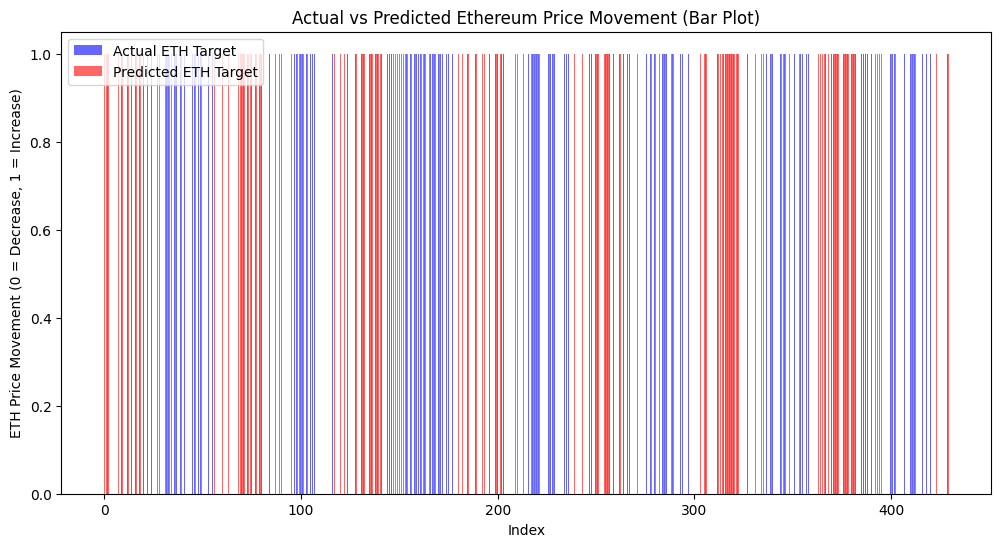

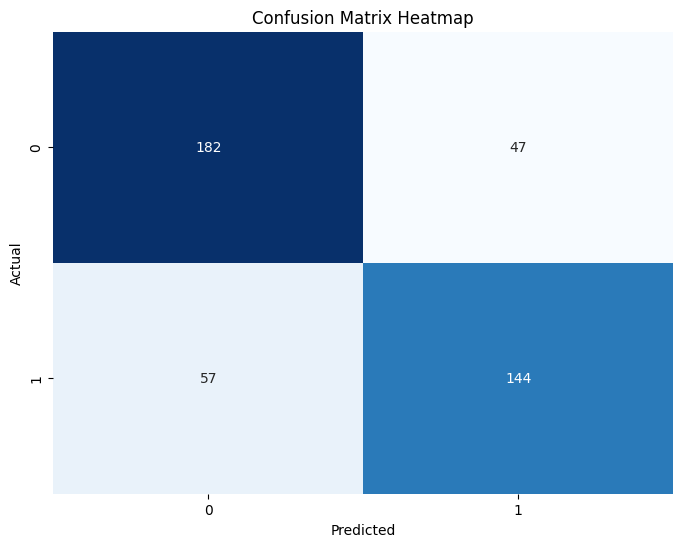

In [2]:
# Plot Actual vs Predicted values (Bar Plot)
x_axis = np.arange(len(X_test))
plt.figure(figsize=(12, 6))
plt.bar(x_axis - 0.2, X_test['Actual_ETH_Target'], width=0.4, label='Actual ETH Target', color='blue', alpha=0.6)
plt.bar(x_axis + 0.2, X_test['Predicted_ETH_Target'], width=0.4, label='Predicted ETH Target', color='red', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('ETH Price Movement (0 = Decrease, 1 = Increase)')
plt.title('Actual vs Predicted Ethereum Price Movement (Bar Plot)')
plt.legend()
plt.show()

# Plot Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

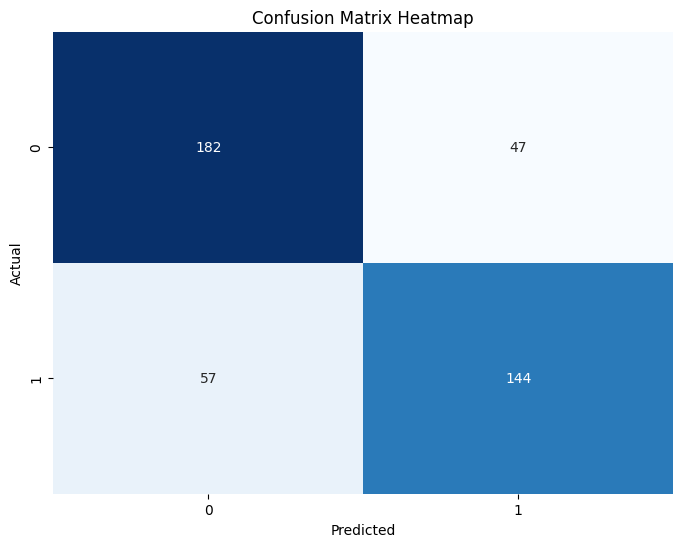

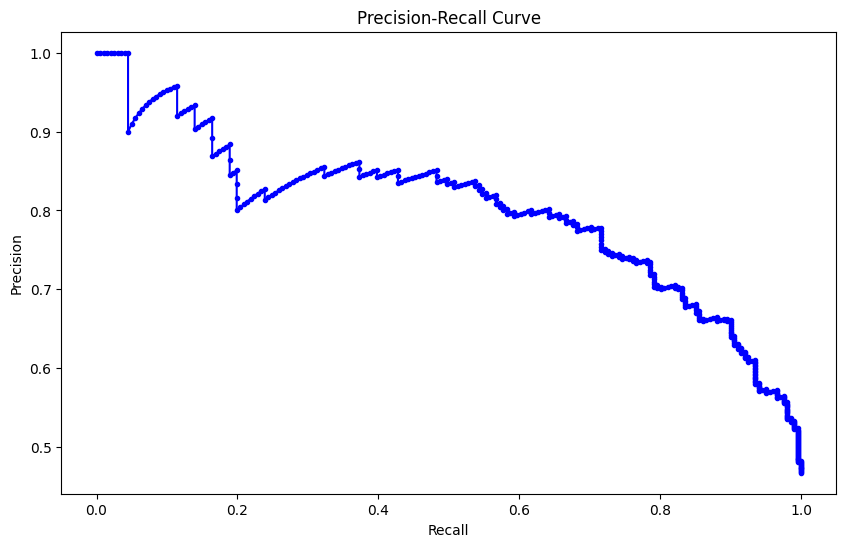

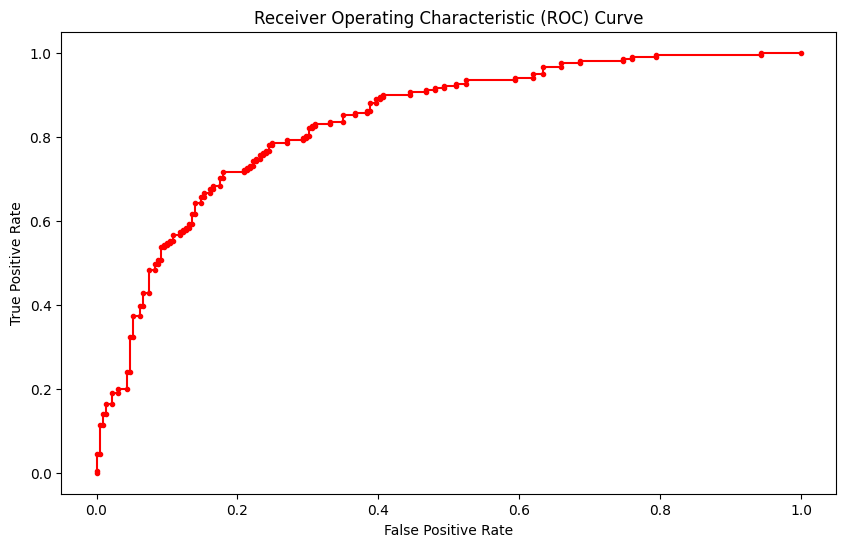

In [3]:
# Plot Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Further Analysis - Precision-Recall Curve and ROC Curve
from sklearn.metrics import precision_recall_curve, roc_curve

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, best_gbm.predict_proba(X_test[features])[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_gbm.predict_proba(X_test[features])[:, 1])
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.', color='r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()
